# Image Segmentation by unsupervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load data

In [159]:
directory_data  = './drive/MyDrive/Colab Notebooks/'
filename_data   = 'assignment_10_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
image_clean     = torch.from_numpy(data['real_images']).float()

## custom data loader for the PyTorch framework

In [160]:
class dataset (Dataset):
    def  __init__(self, data, std_noise):

        noise = torch.randn(data.size()) * std_noise

        self.clean  = data
        self.noisy  = data + noise 

    def __getitem__(self, index):

        clean   = self.clean[index]
        noisy   = self.noisy[index]

        clean = torch.FloatTensor(clean).unsqueeze(dim=0)
        noisy = torch.FloatTensor(noisy).unsqueeze(dim=0)

        return (clean, noisy)
  
    def __len__(self):
        
        return self.clean.shape[0]

In [161]:
image_train = image_clean[::2]
image_test  = image_clean[1::2]

dataset_train   = dataset(image_train, 0.5)
dataset_test    = dataset(image_test, 0.5)

## hyper-parameters

In [162]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
number_epoch    = 300
size_minibatch  = 50
learning_rate   = 0.1
weight_decay    = 0.00001
weight_regular  = 0.00001 #total variation weight

cuda


## construct datasets and dataloaders for training and testing

In [163]:
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [164]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
shape of the label in the training dataset: torch.Size([1, 32, 32])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 32, 32])
shape of the label in the testing dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [165]:
class Network(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Network, self).__init__()
		# more layer, rasidual layer
		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		
		self.conv_encode1	= nn.Conv2d(in_channel , dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
		# self.conv_encode2	= nn.Conv2d(dim_feature * 1, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
		self.conv_encode3	= nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)
		# self.conv_encode4	= nn.Conv2d(dim_feature * 2, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)

		self.conv_middle	= nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True)

		self.conv_decode4 	= nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True)
		# self.conv_decode3 	= nn.Conv2d(dim_feature * 2, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True)
		self.conv_decode2 	= nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True)
		# self.conv_decode1 	= nn.Conv2d(dim_feature * 1, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True)
		self.conv_out 		= nn.Conv2d(dim_feature * 1, out_channel,	kernel_size=1, stride=1, padding=0, bias=True)

		self.ebn1			= nn.BatchNorm2d(dim_feature * 1)
		# self.ebn2			= nn.BatchNorm2d(dim_feature * 1)
		self.ebn3			= nn.BatchNorm2d(dim_feature * 2)
		# self.ebn4			= nn.BatchNorm2d(dim_feature * 2)
	
		self.mbn		 	= nn.BatchNorm2d(dim_feature * 4)
		
		self.dbn4			= nn.BatchNorm2d(dim_feature * 2)
		# self.dbn3			= nn.BatchNorm2d(dim_feature * 2)
		self.dbn2			= nn.BatchNorm2d(dim_feature * 1)
		# self.dbn1			= nn.BatchNorm2d(dim_feature * 1)

		self.activation		= nn.ReLU(inplace=True)
		self.activation_out	= nn.Sigmoid()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		x1  = self.conv_encode1(x)
		eb1 = self.ebn1(x1)
		e1  = self.activation(eb1)
		
		# x2  = self.conv_encode2(e1)
		# eb2 = self.ebn2(x2)
		# e2  = self.activation(eb2)
	
		x3  = self.conv_encode3(e1)
		eb3 = self.ebn3(x3)
		e3  = self.activation(eb3)
	
		# x4  = self.conv_encode4(e3)
		# eb4 = self.ebn4(x4)
		# e4  = self.activation(eb4)
		
		m   = self.conv_middle(e3)
		mb  = self.mbn(m)
		c   = self.activation(mb)
	
		y4  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(c)
		y4  = self.conv_decode4(y4) 
		db4 = self.dbn4(y4)
		d4  = self.activation(db4)
	
		# y3  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d4)
		# y3  = self.conv_decode3(y3) 
		# db3 = self.dbn3(y3)
		# d3  = self.activation(db3)

		y2  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d4)
		y2  = self.conv_decode2(y2) 
		db2 = self.dbn2(y2)
		d2  = self.activation(db2)

		# y1  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d2)
		# y1  = self.conv_decode1(y1) 
		# db1 = self.dbn1(y1)
		# d1  = self.activation(db1)
		
		y1  = self.conv_out(d2)
		y = self.activation_out(y1)

		return y

## build network

In [166]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [73]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================

    return prediction

In [74]:
def compute_estimate(input, prediction):

    number_phase = 2 # bi-partitioning
    (batch, channel, height, width) = input.size()

    estimate = torch.zeros(number_phase, batch, channel).to(device)
    
    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    # ==================================================
    # fill up the blank for the estimate of the inside of segmenting region
    # image - input / phi - prediction_inside
    estimate[0] = torch.mul(input, prediction_inside).sum() / torch.sum(prediction_inside)
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the estimate of the outside of segmenting region
    #
    estimate[1] = torch.mul(input, prediction_outside).sum() / torch.sum(prediction_outside)
    # 
    # ==================================================
    
    return estimate

In [75]:
def compute_loss_data(input, prediction):

    (batch, channel, height, width) = input.size()
    estimate = compute_estimate(input, prediction)

    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    estimate0           = torch.unsqueeze(torch.unsqueeze(estimate[0], dim=-1), dim=-1) 
    estimate1           = torch.unsqueeze(torch.unsqueeze(estimate[1], dim=-1), dim=-1) 
    
    residual_inside     = torch.square(input - estimate0)
    residual_outside    = torch.square(input - estimate1)
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    # sum of (residual_inside * prediction_inside )
    fidelity_inside     = torch.mul(residual_inside, prediction_inside).sum()
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    # sum of (residual_outside * prediction_outside)
    fidelity_outside    = torch.mul(prediction_outside, residual_outside).sum()
    # 
    # ==================================================

    loss_data       = (fidelity_inside + fidelity_outside) / (batch * channel * height * width) 
    loss_data_value = loss_data.item()

    return loss_data, loss_data_value

In [76]:
def compute_regularization(prediction):

    (batch, channel, height, width) = prediction.size()
   
    gradient_height = torch.abs(prediction[:, :, 1:, :] - prediction[:, :, :- 1, :]).sum()
    gradient_width  = torch.abs(prediction[:, :, :, 1:] - prediction[:, :, :, :-1]).sum()

    loss_regularization         = (gradient_height + gradient_width) / (batch * channel * height * width)
    loss_regularization_value   = loss_regularization.item()
    
    return loss_regularization, loss_regularization_value

## compute the loss

In [11]:
def compute_loss(input, prediction, alpha):

    (loss_data, _)              = compute_loss_data(input, prediction)
    (loss_regularization, _)    = compute_regularization(prediction)

    # ==================================================
    # fill up the blank for the loss that consists of the data fidelity and the regularization with a weight
    #
    loss        = loss_data + alpha * loss_regularization
    # 
    # ==================================================

    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [12]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [167]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [14]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [15]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [168]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

100%|██████████| 300/300 [04:08<00:00,  1.21it/s]


---

# functions for visualizing the results 

---

## plot curve

In [39]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [40]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [41]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [42]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [43]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [44]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [45]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [46]:
def function_result_01():

    print('[plot examples of the training noisy images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [47]:
def function_result_02():

    print('[plot examples of the training ground truth images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data, _     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [48]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_train[index_data] 
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [49]:
def function_result_04():

    print('[plot examples of the testing noisy images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [50]:
def function_result_05():

    print('[plot examples of the testing ground truth images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)
   
    data, _     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [51]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [52]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [53]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [54]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [55]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [56]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [57]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [58]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [59]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [60]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [61]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training noisy images]



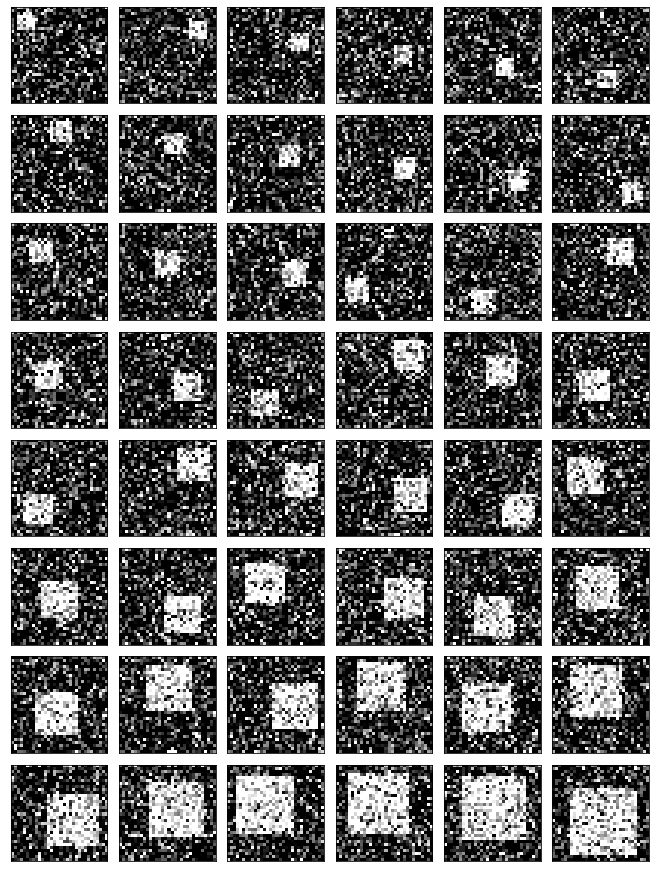


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training ground truth images]



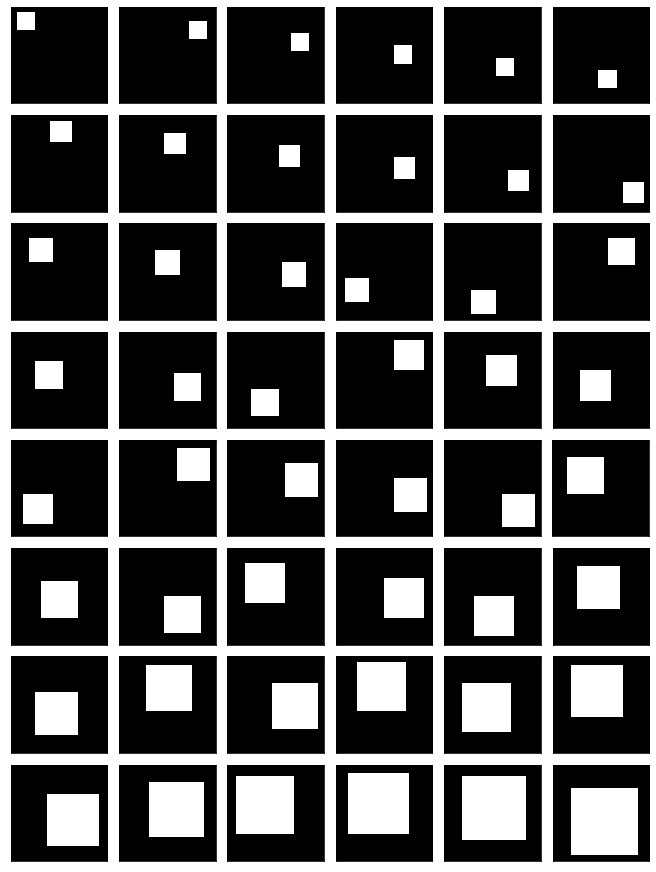


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



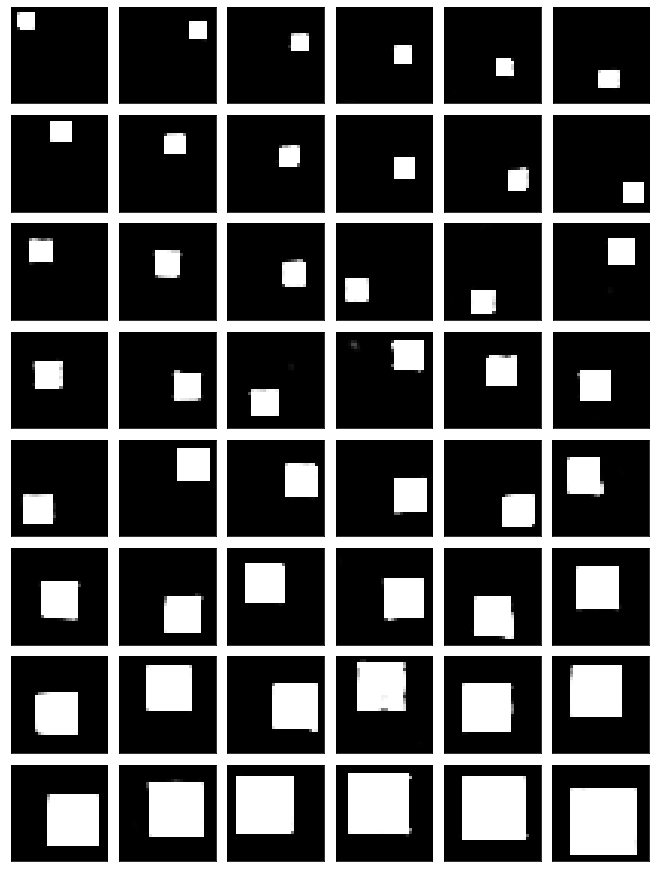


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing noisy images]



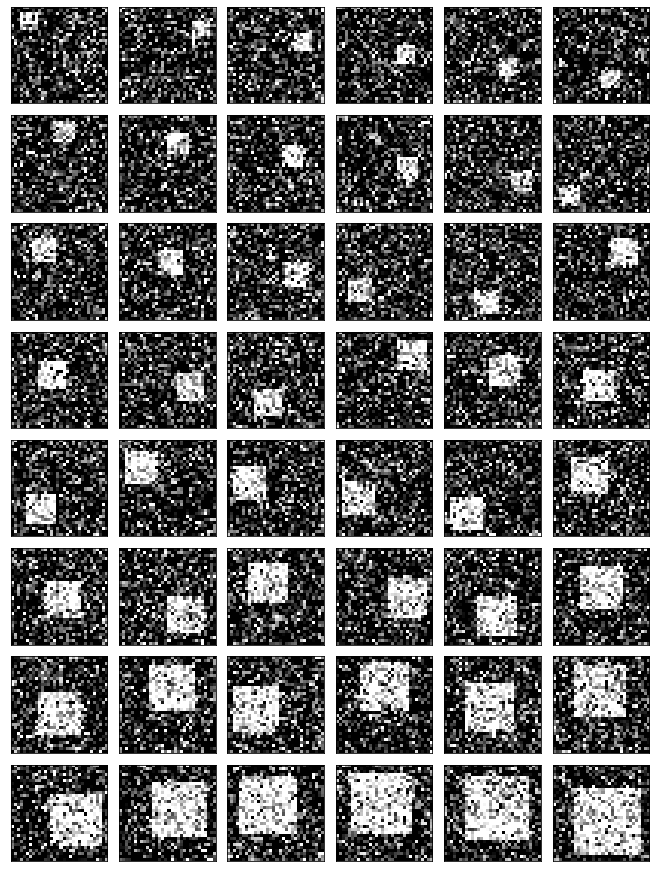


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing ground truth images]



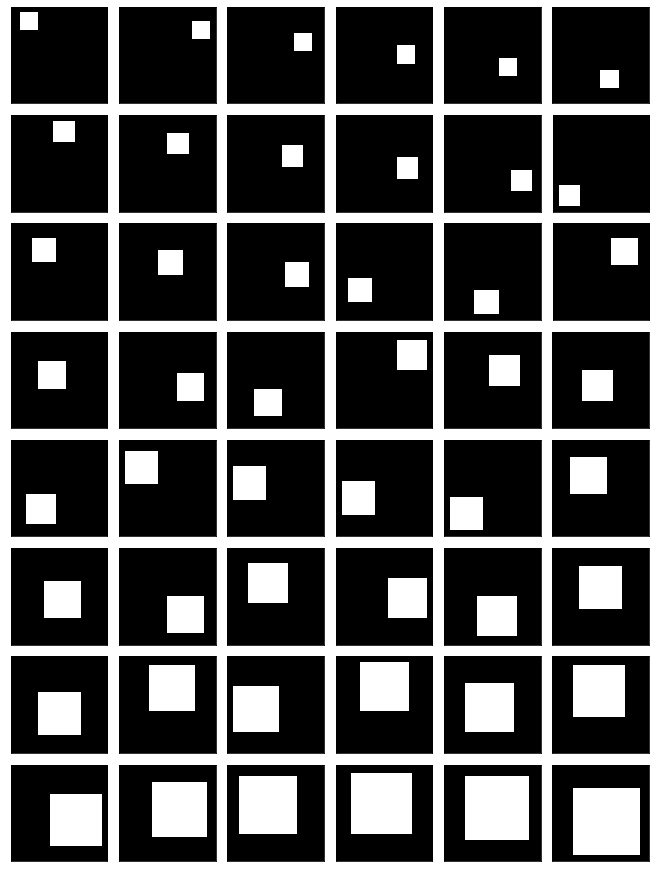


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



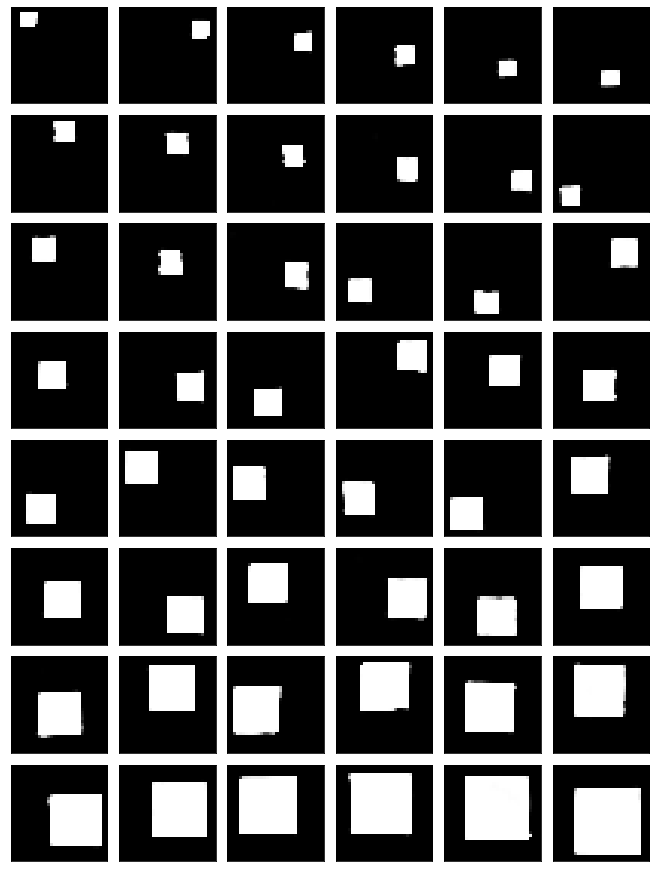


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



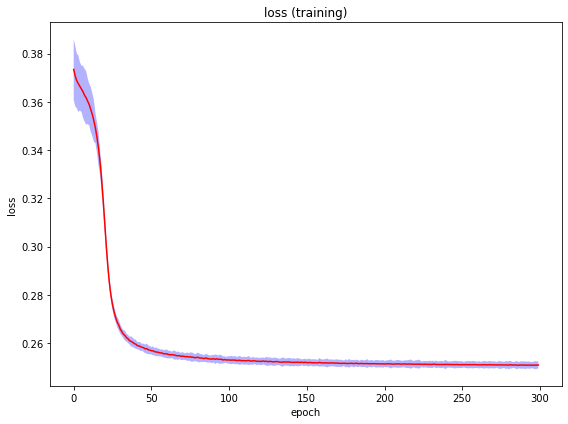


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



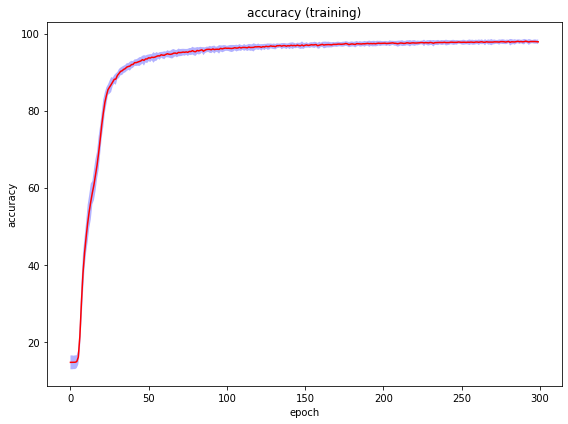


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



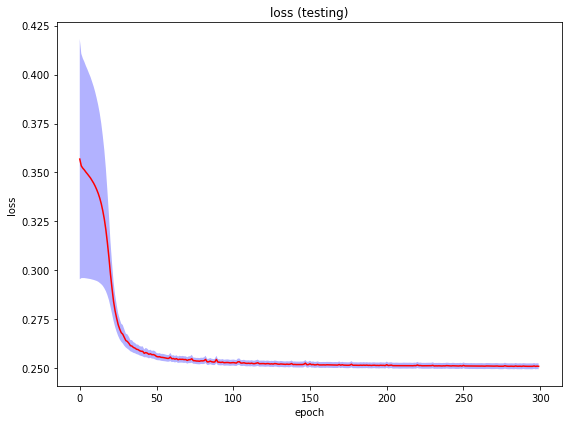


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



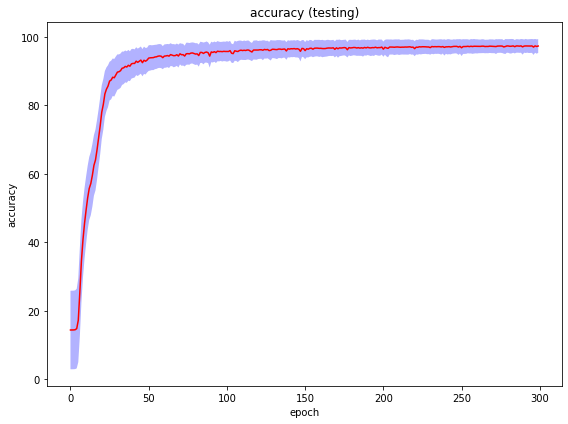


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.2508370093
index =  1, value = 0.2508170470
index =  2, value = 0.2508503517
index =  3, value = 0.2508474859
index =  4, value = 0.2507617321
index =  5, value = 0.2508784086
index =  6, value = 0.2507876047
index =  7, value = 0.2508380701
index =  8, value = 0.2508303630
index =  9, value = 0.2509074031

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 97.8943558035
index =  1, value = 98.0242575771
index =  2, value = 97.9102809209
index =  3, value = 97.8028094166
index =  4, value = 97.9240164088
index =  5, value = 97.9124777057


In [169]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)